# Clasificación Wine Quality (UCI) — 3 clases: malo / normal / bueno

**Dataset:** [Wine Quality](https://archive.ics.uci.edu/dataset/186/wine+quality)

Se ha elegido este dataset, abierto y disponible en el repositorio UCI, con objetivo de aplicar y demostrar las técnicas de análisis y ciencia de datos en general. Usando este, abarcamos un problema diferente a los comunes (financieros, sanitarios...) que pueden llegar a ser un tanto repetitivos.
Espero que esta exploración sea de su gusto.

Se crearon dos conjuntos de datos utilizando muestras de vino tinto y blanco.
Las entradas incluyen pruebas objetivas (por ejemplo, valores de pH) y la salida se basa en datos sensoriales
(media de al menos tres evaluaciones realizadas por expertos en vinos). Cada experto calificó la calidad del vino 
entre 0 (muy malo) y 10 (muy excelente).

**Atributos:**

   1. fixed acidity
   2. volatile acidity
   3. citric acid
   4. residual sugar
   5. chlorides
   6. free sulfur dioxide
   7. total sulfur dioxide
   8. density
   9. pH
   10. sulphates
   11. alcohol
   Output variable (based on sensory data): 
   12. quality (score between 0 and 10)


**Objetivo:**  
Clasificar la calidad de los vinos en tres categorías creadas a partir de `quality`:
- `malo`  : quality ∈ [0, 4]
- `normal`: quality ∈ [5, 6]
- `bueno` : quality ∈ [7, 10]

Se trabaja con ambos datasets (vino tinto y blanco). El pipeline incluye:
- carga y unión de datos
- preprocesado y creación de etiquetas
- EDA y análisis del desbalance de clases
- selección de variables (ANOVA, mutual information, RFE, RandomForest importance)
- entrenamiento y evaluación de modelos (LogisticRegression, kNN, RandomForest, SVC)
- guardado de resultados

## 1. Imports y configuración general

In [72]:
# Librerías del sistema
import os
from pathlib import Path
import zipfile
import io
import urllib.request

# Librerías de datos
import numpy as np
import pandas as pd

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocesado y selección
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# Evaluación
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score

# Utilidades
import joblib
import warnings
from tabulate import tabulate

warnings.filterwarnings("ignore")

# Directorios
BASE_DIR = Path('.').resolve().parent if (Path('.').resolve().name == 'notebooks') else Path('.').resolve()
DATA_RAW = BASE_DIR / 'data' / 'raw'
ARTIFACTS = BASE_DIR / 'artifacts'
REPORTS = BASE_DIR / 'reports'
FIGURES = REPORTS / 'figures'
RANDOM_STATE = 42

# Crear directorios si no existen
for p in [DATA_RAW, ARTIFACTS, REPORTS, FIGURES]:
    p.mkdir(parents=True, exist_ok=True)

# Mostrar todas las columnas en pandas
pd.set_option('display.max_columns', None)

## 2. Carga de datos (red + white) desde UCI

En esta celda se descarga y extrae el dataset de vinos desde la UCI en la carpeta data/raw creada en la celda anterior.

In [73]:
# Descargar y cargar el dataset de vinos desde UCI
uci_zip_url = "https://archive.ics.uci.edu/static/public/186/wine+quality.zip"
zip_path = DATA_RAW / "wine+quality.zip"

if not zip_path.exists():
    print("Descargando dataset desde UCI...")
    with urllib.request.urlopen(uci_zip_url) as resp:
        content = resp.read()
    zip_path.write_bytes(content)
    print(f"Guardado en {zip_path}")

# Extraer el contenido del ZIP en DATA_RAW
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(DATA_RAW)
    print(f"Contenido extraído en {DATA_RAW}")

Contenido extraído en C:\Users\belop\Documents\Trabajo\Capgemini\CBL-TestDataScience-1\data\raw


Lectura de los archivos csv y creación de los dataframes para su procesamiento, concatenación de ambos datasets y muestra de las primeras filas.

In [74]:
# Cargar (el separador en estos CSVs es ';')
df_red = pd.read_csv(DATA_RAW / 'winequality-red.csv', sep=';')
df_white = pd.read_csv(DATA_RAW / 'winequality-white.csv', sep=';')

# Añadir columna tipo y concatenar
df_red['type'] = 'red'
df_white['type'] = 'white'
df = pd.concat([df_red, df_white], ignore_index=True)

# Mostrar tamaño y primeras filas
print("Red:", df_red.shape, "White:", df_white.shape, "Total:", df.shape)
df.head()

Red: (1599, 13) White: (4898, 13) Total: (6497, 13)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


## 2. EDA.- Análisis Exploratorio

Información del DataFrame, tipos de datos y nulos.
Aquí vemos que no hay nulos y todos los tipos son correctos.

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  type                  6497 non-null   object 
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


Descripción de cada variable. 
Podemos observar datos interesantes como:
- Ningún juez ha evaluado ningún vino por debajo de 3 ni por encima de 9.
- Viendo los percentiles de la etiqueta calidad, podemos adelantar una idea de que la clase normal va a ser la mayoritaria.
- El alcohol varía desde 8 a 14.0 grados, teniendo una media de 10.5º.

In [76]:
# Descripción estadística.
df.describe().T

,count,mean,std,min,25%,50%,75%,max
fixed acidity,6497.0,7.215307,1.296434,3.80000,6.40000,7.00000,7.70000,15.90000
volatile acidity,6497.0,0.339666,0.164636,0.08000,0.23000,0.29000,0.40000,1.58000
citric acid,6497.0,0.318633,0.145318,0.00000,0.25000,0.31000,0.39000,1.66000
residual sugar,6497.0,5.443235,4.757804,0.60000,1.80000,3.00000,8.10000,65.80000
chlorides,6497.0,0.056034,0.035034,0.00900,0.03800,0.04700,0.06500,0.61100
free sulfur dioxide,6497.0,30.525319,17.749400,1.00000,17.00000,29.00000,41.00000,289.00000
total sulfur dioxide,6497.0,115.744574,56.521855,6.00000,77.00000,118.00000,156.00000,440.00000
density,6497.0,0.994697,0.002999,0.98711,0.99234,0.99489,0.99699,1.03898
pH,6497.0,3.218501,0.160787,2.72000,3.11000,3.21000,3.32000,4.01000
sulphates,6497.0,0.531268,0.148806,0.22000,0.43000,0.51000,0.60000,2.00000


### Análisis Univariante

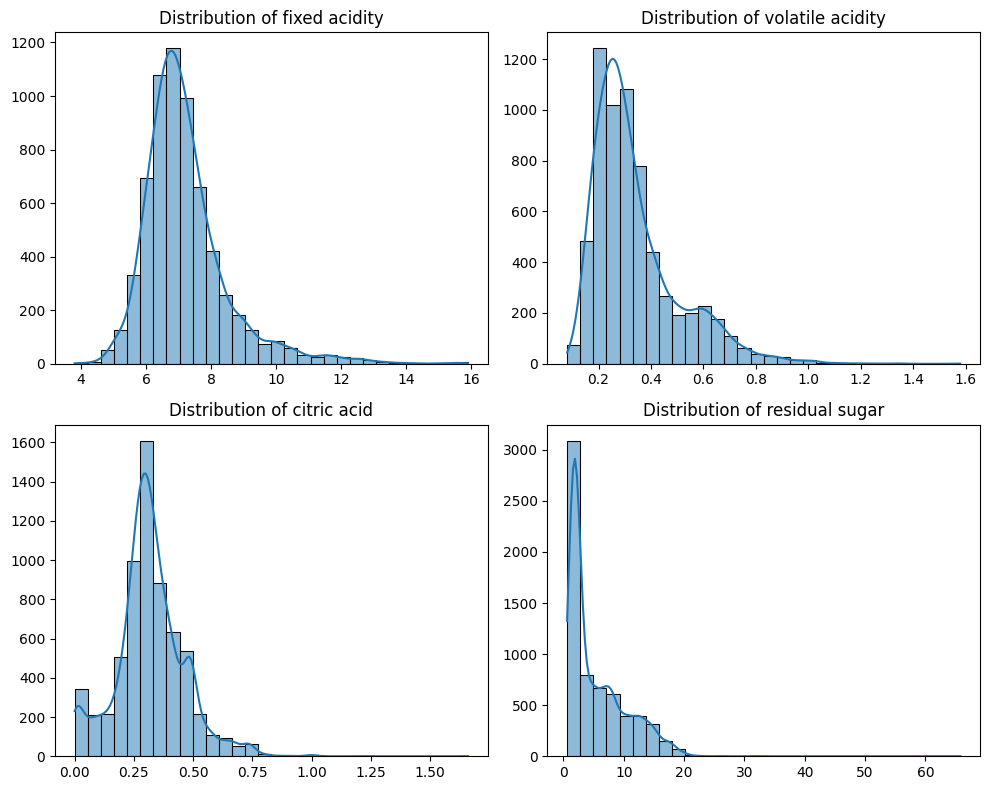

In [77]:
# Visualización de distribuciones de algunas características
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
attributes = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar']

for i, col in enumerate(attributes):
    ax = axes[i // 2, i % 2]
    if df[col].dtype in ['float64', 'int64']:
        sns.histplot(df[col], kde=True, bins=30, ax=ax)
        ax.set_title(f'Distribution of {col}')
    else:
        sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=ax)
        ax.set_title(f'Count plot of {col}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig(FIGURES/ "univariant.jpg", dpi=300, bbox_inches="tight")
plt.show()

La mayoría de todos los atributos siguen una distribución Gaussiana, sin embargo otros (como residal sugar o free sulfur dioxide) se comportan de diferente manera.

### Análisis Multivariante

#### Análisis de Relaciones entre Variables

En este análisis se presentan varios gráficos informativos que muestran cómo se relacionan las variables del dataset. A continuación, se destacan algunos puntos clave:

- **Acidez Volátil (`volatile acidity`)**:  
    A simple vista, se observa que un alto nivel de acidez volátil influye negativamente en la calidad del vino. Los vinos con mayor acidez volátil tienden a obtener peores puntuaciones de calidad.

- **Acidez Fija (`fixed acidity`) y Acidez Cítrica (`citric acid`)**:  
    Estas variables no muestran una relación clara con la calidad del vino. Se pueden encontrar vinos de todas las calidades a lo largo de todo su rango.

- **Alcohol**:  
    Como veremos más adelante, el contenido de alcohol es el atributo que más influye en la calidad del vino. A mayor cantidad de alcohol, las puntuaciones de calidad tienden a ser más altas.

Estos hallazgos iniciales nos proporcionan una visión general de cómo ciertas características químicas afectan la percepción de calidad del vino. En las siguientes secciones, profundizaremos en estas relaciones con análisis más detallados.

Se añade además, como curiosidad, un gráfico que muestra una leve cantidad de alcohol media en el vino blanco frente al vino tinto.

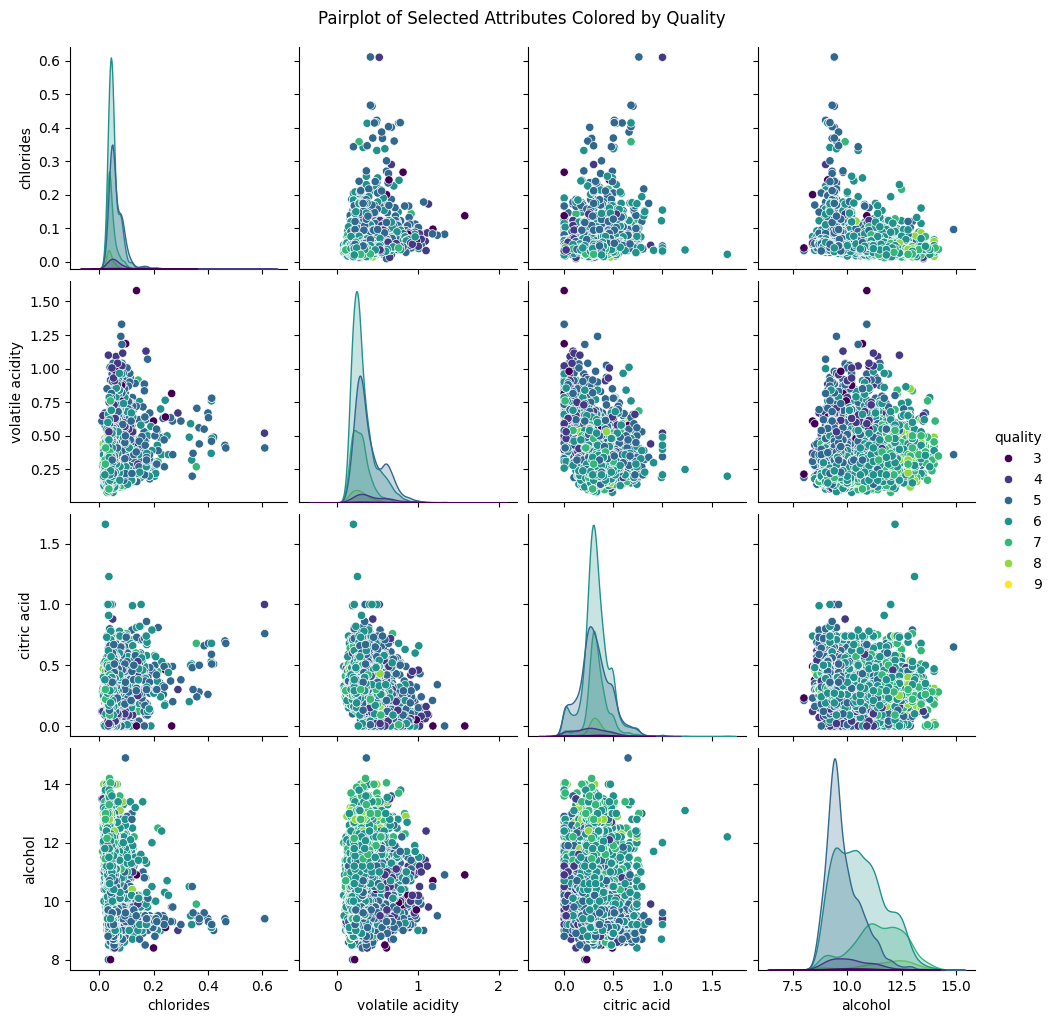

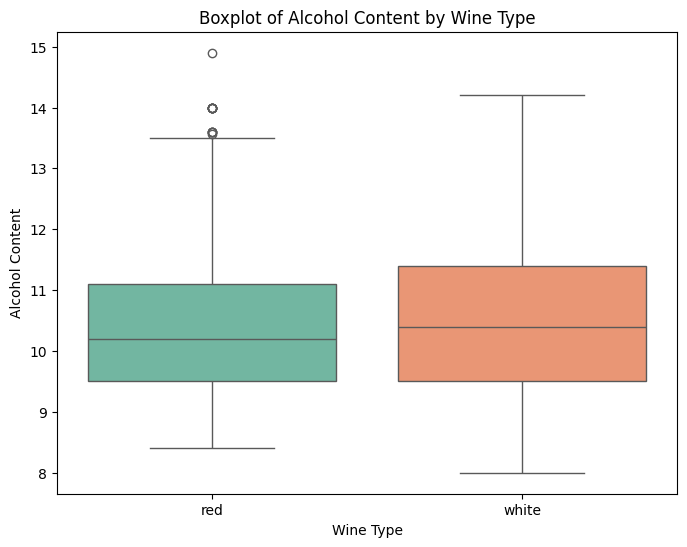

In [78]:
# Pairplot for selected attributes
selected_attributes = ['chlorides', 'volatile acidity', 'citric acid', 'alcohol', 'quality']
sns.pairplot(df[selected_attributes], hue='quality', palette='viridis', diag_kind='kde')
plt.suptitle("Pairplot of Selected Attributes Colored by Quality", y=1.02)
plt.show()

# Boxplot of alcohol content by wine type
plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='alcohol', data=df, palette='Set2')
plt.title("Boxplot of Alcohol Content by Wine Type")
plt.xlabel("Wine Type")
plt.ylabel("Alcohol Content")
plt.savefig(FIGURES/ "multivariant.jpg", dpi=300, bbox_inches="tight")
plt.show()

### Correlación entre variables numéricas

Acompañando al análisis anterior, esta matriz de correlación contrasta las afirmaciones realizadas previamente. Ej: Alcohol es el atributo con mayor correlación.

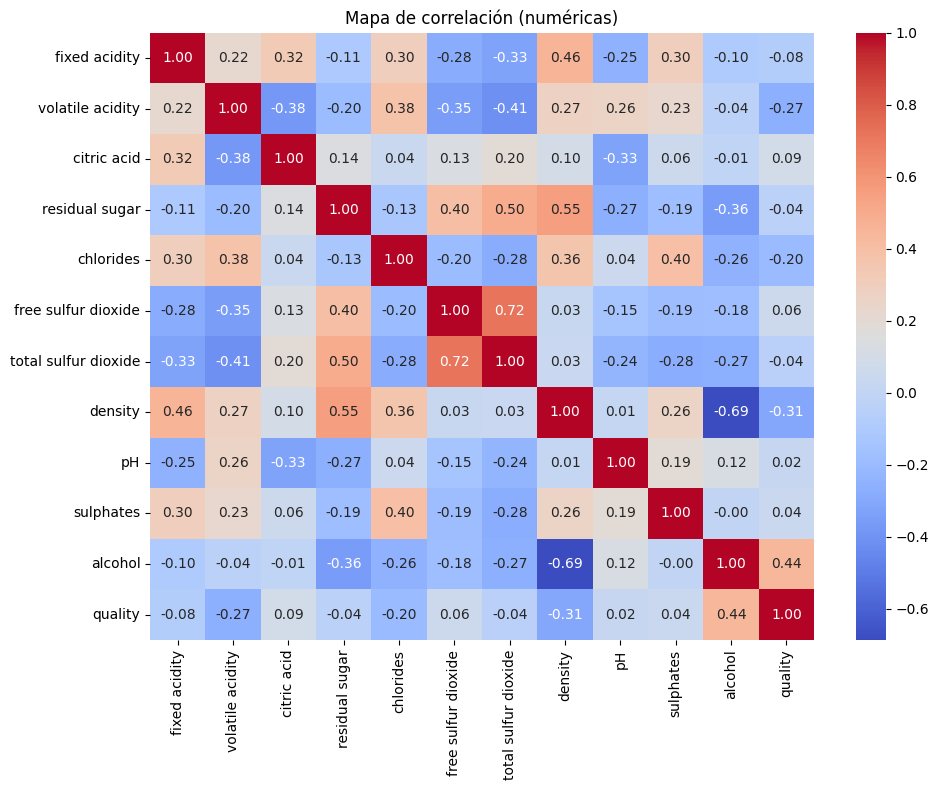

In [79]:
# Calcular la matriz de correlación y definir columnas numéricas
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr = df[num_cols].corr()

# Correlación entre numéricas (para una idea general)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=num_cols, yticklabels=num_cols)
plt.title('Mapa de correlación (numéricas)')
plt.tight_layout()
plt.savefig(FIGURES/ "correlation_matrix.jpg", dpi=300, bbox_inches="tight")
plt.show()

### Creación de etiquetas (malo/normal/bueno)

label_name
normal    4974
bueno     1277
malo       246
Name: count, dtype: int64


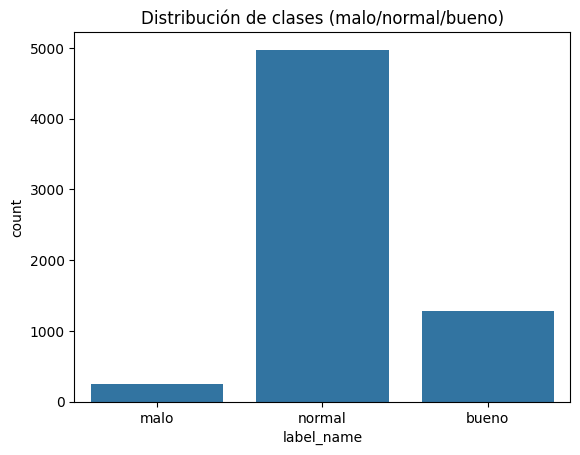

In [80]:
# Definir función de etiquetado
# Crear etiquetas y nombres de etiquetas en una sola línea
df['label'] = pd.cut(df['quality'], bins=[-1, 4, 6, 10], labels=[0, 1, 2]).astype('int64')
df['label_name'] = df['label'].map({0: 'malo', 1: 'normal', 2: 'bueno'})

# Distribución de clases
print(df['label_name'].value_counts())
sns.countplot(x='label_name', data=df, order=['malo','normal','bueno'])
plt.title("Distribución de clases (malo/normal/bueno)")
plt.savefig(FIGURES/ "class_distribution.jpg", dpi=300, bbox_inches="tight")
plt.show()


**Observación:** se observa un fuerte desbalance (clase `normal` dominante).  
Esto afecta el entrenamiento, por eso, más abajo se discuten técnicas de Data Augmentation.

## 3. Limpieza y preparación de datos

In [81]:
# Eliminamos las columnas innecesarias y definimos X e y
exclude = ['quality','label','label_name','type']
feature_names = [c for c in df.columns if c not in exclude]
X = df[feature_names].copy()
y = df['label'].copy()

# Guardar nombres
print("Features utilizadas:", feature_names)

# Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Guardar el scaler para uso futuro
joblib.dump(scaler, ARTIFACTS / 'scaler.pkl')

# Partición para guardar y futura predicción desde archivo
_, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
X_test.to_csv(DATA_RAW / 'prueba_test.csv', index=False)


# Partición estratificada train/test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

print("Train:", X_train.shape, "Test:", X_test.shape)

Features utilizadas: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
Train: (5197, 11) Test: (1300, 11)


## Selección de variables

Debido a la alta correlación entre variables y a la poca aportación aparente de algunas a la etiqueta de calidad, se utilizarán algoritmos de selección de variables para continuar sólo con las más importantes.

Probamos 4 enfoques:
- SelectKBest (ANOVA F-test)
- RFE con RandomForest como estimador base
- Importancias de RandomForest (top k variables)

In [82]:
# Por iteración y visuaización de resultados en la selección de variables se selecciona una k = 7
k = 7  # número de features a seleccionar

# 1) ANOVA F-test
skb_anova = SelectKBest(score_func=f_classif, k=k).fit(X_train, y_train)
anova_selected = [f for f, s in zip(feature_names, skb_anova.get_support()) if s]
print("ANOVA selected:", anova_selected)

# 2) RFE con RandomForest
rf_base = RandomForestClassifier(n_estimators=200, random_state=42)
rfe = RFE(estimator=rf_base, n_features_to_select=k)
rfe.fit(X_train, y_train)
rfe_selected = [f for f, s in zip(feature_names, rfe.support_) if s]
print("RFE selected:", rfe_selected)

# 3) RandomForest importances (top-k)
rf_fit = RandomForestClassifier(n_estimators=200, random_state=42).fit(X_train, y_train)
importances = rf_fit.feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False)
rf_selected = imp_df.head(k)['feature'].tolist()
print("RandomForest top-k:", rf_selected)

# Guardar resultados de selección
fs_df = pd.DataFrame({
    'feature': feature_names,#####asdasdaasdasdasdasd
    'anova_score': skb_anova.scores_,
    'rf_importance': importances
}).sort_values('rf_importance', ascending=False)
fs_df.to_csv(os.path.join(REPORTS, 'feature_selection_summary.csv'), index=False)
fs_df.head(12)

selected_sets = {
    'all': feature_names,
    # 'anova_k7': anova_selected,
    # 'rfe_k7': rfe_selected,
    'rf_top_k7': rf_selected
}
selected_sets

ANOVA selected: ['volatile acidity', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'alcohol']
RFE selected: ['volatile acidity', 'chlorides', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
RandomForest top-k: ['alcohol', 'density', 'volatile acidity', 'total sulfur dioxide', 'chlorides', 'sulphates', 'free sulfur dioxide']


{'all': ['fixed acidity',
  'volatile acidity',
  'citric acid',
  'residual sugar',
  'chlorides',
  'free sulfur dioxide',
  'total sulfur dioxide',
  'density',
  'pH',
  'sulphates',
  'alcohol'],
 'rf_top_k7': ['alcohol',
  'density',
  'volatile acidity',
  'total sulfur dioxide',
  'chlorides',
  'sulphates',
  'free sulfur dioxide']}

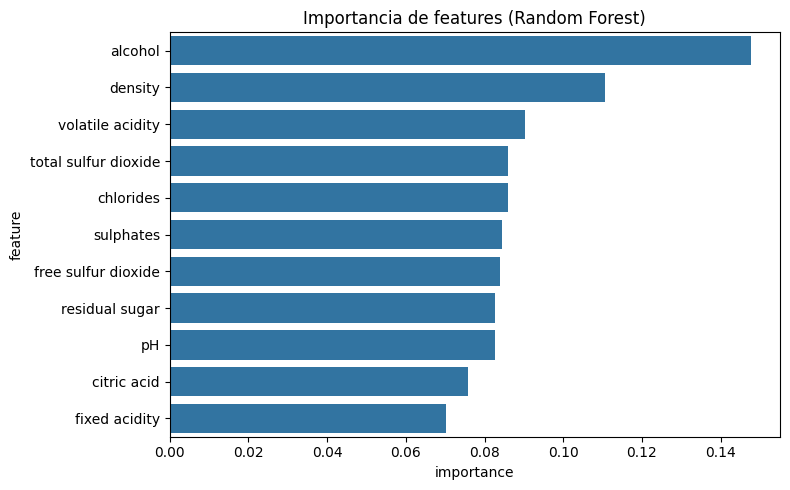

In [83]:
plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=imp_df, orient='h')
plt.title("Importancia de features (Random Forest)")
plt.tight_layout()
plt.savefig(FIGURES/ "features_importance.jpg", dpi=300, bbox_inches="tight")
plt.show()

Seleccionamos los 7 mejores atributos elegidos por los métodos de selección de variables. Al ser los tres muy parecidos, escojo uno indiferentemente.

## Entrenamiento e hiperparametrización

In [84]:
# Creación de una función para entrenar y evaluar modelos

def evaluate_models_with_grid(param_grid: dict, selected_sets: dict, X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray, feature_names: list) -> list[dict]:
    """Evalúa múltiples modelos con GridSearchCV y diferentes conjuntos de características.
    Cada resultado de cada modelo se almacena en un diccionario. 
    Cada diccionario se añade a una lista que se devuelve al final.

    Args:
        param_grid (dict): Espacio de hiperparámetros para cada modelo junto con el estimador. dict{'model_name': (estimator, param_grid)}
        selected_sets (dict): Conjuntos de características a evaluar. dict{'set_name': [feature1, feature2, ...]}
        X_train (np.ndarray): Conjunto de entrenamiento.
        X_test (np.ndarray): Conjunto de test.
        y_train (np.ndarray): Conjunto de etiquetas de entrenamiento.
        y_test (np.ndarray): Conjunto de etiquetas de test.
        feature_names (list): Nombres de todas las características.

    Returns:
        list[dict]: Lista de diccionarios con resultados e hiperparámetros de cada modelo y conjunto de características.
    """
    results = []
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

    for set_name, feat_list in selected_sets.items():
        idxs = [feature_names.index(f) for f in feat_list]
        idxs.sort()
        X_tr_sub = X_train[:, idxs]
        X_te_sub = X_test[:, idxs]

        for params in param_grid:
            # GridSearch sobre todos los modelos y sus hiperparámetros
            grid = GridSearchCV(param_grid[params][0], param_grid[params][1], cv=cv, scoring='f1_macro', n_jobs=-1, verbose=2)
            grid.fit(X_tr_sub, y_train)

            best_model = grid.best_estimator_
            y_pred = best_model.predict(X_te_sub)

            acc = accuracy_score(y_test, y_pred)
            f1_macro = f1_score(y_test, y_pred, average='macro')
            recall_macro = recall_score(y_test, y_pred, average='macro')
            report = classification_report(y_test, y_pred, target_names=['malo','normal','bueno'], output_dict=True)

            results.append({
                'Algorithm': params,
                'best_model': best_model,
                'best_params': grid.best_params_,
                'feature_set': set_name,
                'cv_mean_acc': grid.best_score_,
                'cv_std_acc': np.std(grid.cv_results_['mean_test_score']),
                'test_acc': acc,
                'test_f1_macro': f1_macro,
                'test_recall_macro': recall_macro,
                'report': report,
                'y_pred': y_pred
            })
    return results

Espacio de hiperparametrización a usar

In [85]:
param_grid = {
    'Logistic Regression':
        (
            LogisticRegression(max_iter=200, random_state=RANDOM_STATE),
            {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs', 'saga']
            },
        ),
    'KNN':
        (
            KNeighborsClassifier(),
            {   
                'n_neighbors': [3, 5, 7],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan']
            }
        ),
    'Random Forest':
        (
            RandomForestClassifier(random_state=RANDOM_STATE),
            {   
                'n_estimators': [100, 200, 300],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5, 10]
            },
        ),
    'SVM':
        (
            SVC(random_state=RANDOM_STATE),
        {   
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf', 'poly'],
            'gamma': ['scale', 'auto']
        },
        ),
    'Gradient Boosting':
        (
            GradientBoostingClassifier(random_state=RANDOM_STATE),
            {
                'n_estimators': [100, 200],
                'learning_rate': [0.01, 0.1],
                'max_depth': [3, 5, 7]
            },
        ),
    'MLP':
        (
            MLPClassifier(max_iter=300, random_state=RANDOM_STATE),
            {
                'hidden_layer_sizes': [(50,), (100,), (100,50)],
                'activation': ['relu'],
                'solver': ['adam', 'sgd']
            },
        ),
    'Decision Tree':
        (
            DecisionTreeClassifier(random_state=RANDOM_STATE),
        {   
            'max_depth': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10]
        }
        ),
}

Ejecución del entrenamiento

In [86]:
results = evaluate_models_with_grid(
    param_grid, 
    selected_sets, 
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    feature_names)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


Disposición de resultados

In [87]:

# Convertimos a tabla
df_results = pd.DataFrame([{
    'Modelo': r['best_model'],
    'Algoritmo': r['Algorithm'],
    'Feature Set': r['feature_set'],
    'Best Params': r['best_params'],
    'CV Mean Acc': r['cv_mean_acc'],
    'CV Std Acc': r['cv_std_acc'],
    'Test Acc': r['test_acc'],
    'Test F1 Macro': r['test_f1_macro'],
    'Test Recall Macro': r['test_recall_macro']
} for r in results])

# Ordenar por Test F1 Macro en orden descendente
df_results = df_results.sort_values(by='Test F1 Macro', ascending=False)

# Resultados en formato tabla
print(tabulate(
    df_results[['Algoritmo', 'Feature Set', 'CV Mean Acc', 'Test Acc', 'Test F1 Macro', 'Test Recall Macro']],
    headers='keys',
    tablefmt='fancy_grid',
    showindex=False
))
df_results.to_csv(os.path.join(REPORTS, 'model_comparison_results.csv'), index=False)

╒═════════════════════╤═══════════════╤═══════════════╤════════════╤═════════════════╤═════════════════════╕
│ Algoritmo           │ Feature Set   │   CV Mean Acc │   Test Acc │   Test F1 Macro │   Test Recall Macro │
╞═════════════════════╪═══════════════╪═══════════════╪════════════╪═════════════════╪═════════════════════╡
│ Gradient Boosting   │ all           │      0.5783   │   0.846154 │        0.608803 │            0.571115 │
├─────────────────────┼───────────────┼───────────────┼────────────┼─────────────────┼─────────────────────┤
│ Random Forest       │ all           │      0.562414 │   0.857692 │        0.606183 │            0.567073 │
├─────────────────────┼───────────────┼───────────────┼────────────┼─────────────────┼─────────────────────┤
│ KNN                 │ all           │      0.582559 │   0.812308 │        0.605452 │            0.583514 │
├─────────────────────┼───────────────┼───────────────┼────────────┼─────────────────┼─────────────────────┤
│ Gradient Boosting

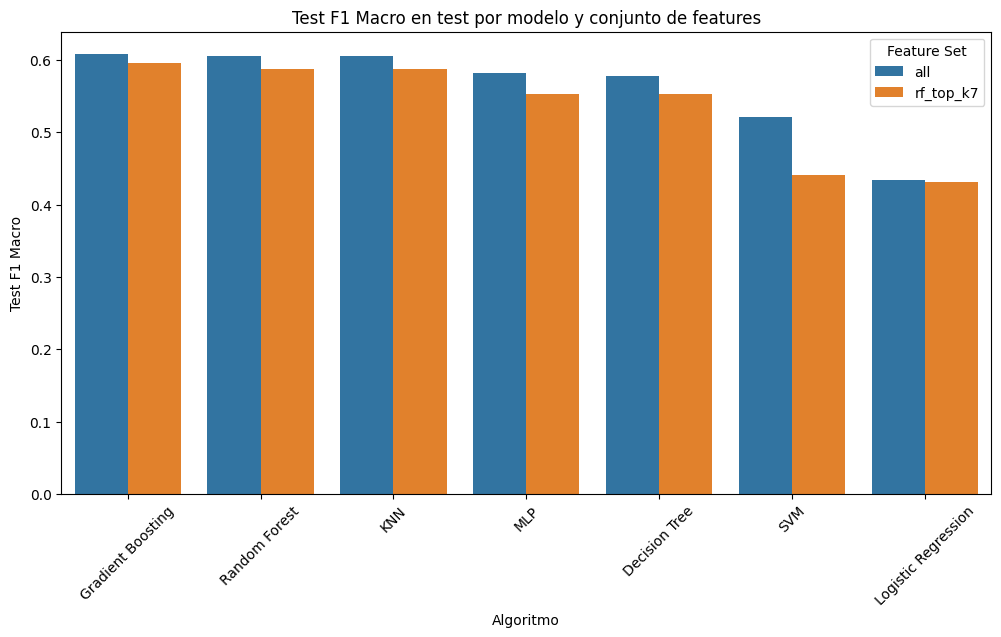

In [88]:
plt.figure(figsize=(12,6))
sns.barplot(data=df_results, x="Algoritmo", y="Test F1 Macro", hue="Feature Set")
plt.title("Test F1 Macro en test por modelo y conjunto de features")
plt.xticks(rotation=45)
plt.savefig(FIGURES/ "F1_Score_comparison.jpg", dpi=300, bbox_inches="tight")
plt.show()

A excepción de Support Vector Machines y Logistic Regression, todos los algoritmos se comportan de manera similar, obteniendo Gradient Boosting mejor resultado con la semilla fija a 42.

Además, se observa que los entrenamientos que utilizan todos los atributos presentan un mejor desempeño en comparación con aquellos que emplean solo los 7 seleccionados. Esto se debe a que el problema cuenta con pocos atributos y la mayoría de ellos (a excepción de los tres o cuatro más importantes) aportan información de manera similar. Si bien podría considerarse aumentar el número de atributos seleccionados, incluir todos no representa un costo computacional significativo debido al tamaño reducido del dataset. Por lo tanto, mantener todos los atributos resulta más práctico y efectivo según los resultados obtenidos.

### Análisis de Matriz de Confusión de mejor modelo

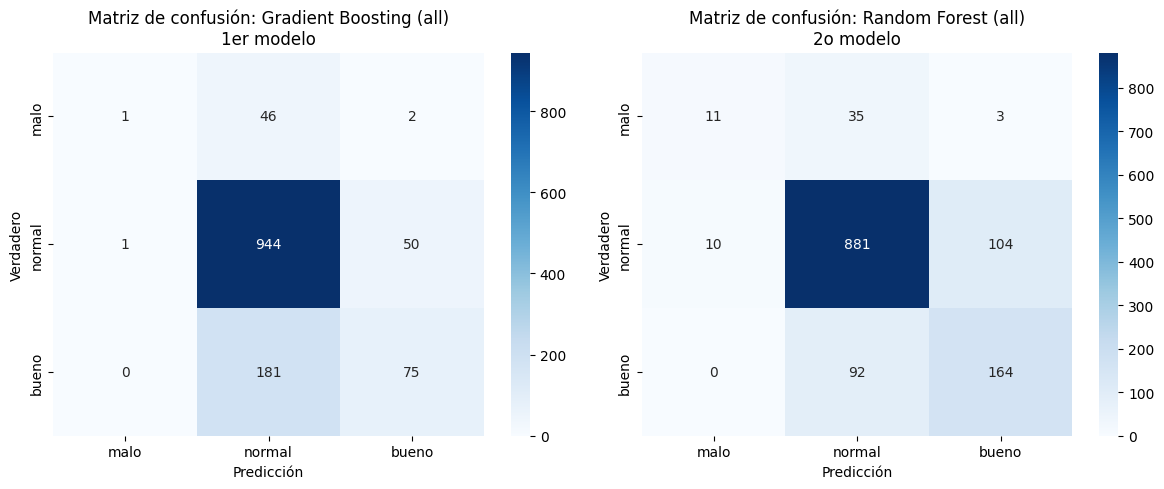

Mejor en Test F1 Macro:
 Modelo               ([DecisionTreeRegressor(criterion='friedman_ms...
Algoritmo                                            Gradient Boosting
Feature Set                                                        all
Best Params          {'learning_rate': 0.1, 'max_depth': 7, 'n_esti...
CV Mean Acc                                                     0.5783
CV Std Acc                                                    0.072957
Test Acc                                                      0.846154
Test F1 Macro                                                 0.608803
Test Recall Macro                                             0.571115
Name: 4, dtype: object


Mejor en Test Acc:
 Modelo               (DecisionTreeClassifier(max_depth=20, max_feat...
Algoritmo                                                Random Forest
Feature Set                                                        all
Best Params          {'max_depth': 20, 'min_samples_split': 2, 'n_e...
CV Mean

In [89]:
# Buscamos el mejor resultado por Test F1 Macro
best_row_f1 = df_results.iloc[0]

y_pred_f1 = results[0]['y_pred']
cm_f1 = confusion_matrix(y_test, y_pred_f1)

# Buscamos el segundo mejor resultado
second_best_row_f1 = df_results.iloc[1]

second_y_pred_f1 = results[1]['y_pred']
second_cm = confusion_matrix(y_test, second_y_pred_f1)

# Mostrar ambas matrices de confusión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Blues', xticklabels=['malo', 'normal', 'bueno'], yticklabels=['malo', 'normal', 'bueno'], ax=axes[0])
axes[0].set_title(f'Matriz de confusión: {best_row_f1["Algoritmo"]} ({best_row_f1["Feature Set"]})\n1er modelo')
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Verdadero')

sns.heatmap(second_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['malo', 'normal', 'bueno'], yticklabels=['malo', 'normal', 'bueno'], ax=axes[1])
axes[1].set_title(f'Matriz de confusión: {second_best_row_f1["Algoritmo"]} ({second_best_row_f1["Feature Set"]})\n2o modelo')
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Verdadero')

plt.tight_layout()
plt.savefig(FIGURES/ "confussion_matrix.jpg", dpi=300, bbox_inches="tight")
plt.show()
print("Mejor en Test F1 Macro:\n", best_row_f1)
print("\n")
print("Mejor en Test Acc:\n", second_best_row_f1)


Viendo ambos modelos con parecidos resultados, no es tan importante la selección de uno o de otro. En mi caso, usaré el segundo porque considero que generaliza mejor y predice más de las clases minoritarias.

In [90]:
# Guardar el modelo seleccionado
joblib.dump((second_best_row_f1['Modelo'], ['malo', 'normal', 'bueno']), ARTIFACTS / 'best_model_RF.pkl')
# Si guardamos este modelo recordar que usa las features:
print(second_best_row_f1['Feature Set'])

all



Las clases "malo" y "bueno" obtienen resultados bajos, esto es sobre todo debido al desbalanceo de clases. Los modelos sobreaprenden la clase dominante y no son capaces de generalizar.
Frente a este problema, se pueden aplicar varias técnicas para mejorar la predicción:
  - Ajustar `class_weight='balanced'` en modelos que lo soporten (p.ej. LogisticRegression, RandomForest, SVC).
  - Aplicar sobremuestreo (SMOTE) o submuestreo en el set de entrenamiento.
  - Evaluar métricas macro (F1-macro) y por clase en lugar de solo accuracy (ya realizado).

Sin embargo, es desbalance de clases en este problema es tal, que aplicar tales técnicas no influye apenas en los resultados.

Veamos a continuación un ejemplo de usar `class_weight = 'balanced'` y otro de usar SMOTE.

#### Ejemplo de class_weight = 'balanced'

In [91]:
model = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=['malo','normal','bueno'], output_dict=True)

print("Accuracy balanced weights:", acc)

model = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_macro')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average='macro')
report = classification_report(y_test, y_pred, target_names=['malo','normal','bueno'], output_dict=True)

print("Accuracy normal weights:", acc)

Accuracy balanced weights: 0.85
Accuracy normal weights: 0.8561538461538462


#### Aplicar Smote (técnica de Data Augmentation)

In [92]:
gb = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 100, random_state=RANDOM_STATE)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("Accuracy sin SMOTE:", accuracy_score(y_test, y_pred_gb))
print(classification_report(y_test, y_pred_gb, target_names=['malo','normal','bueno']))
print()
sm = SMOTE(sampling_strategy={0: 500, 2: 1500}, random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train, y_train)
print("Antes:", np.bincount(y_train), "Después:", np.bincount(y_res))
# Re-entrenar un modelo con X_res, y_res y evaluar en X_test
gb_sm = GradientBoostingClassifier(learning_rate = 0.1, max_depth = 7, n_estimators = 100, random_state=RANDOM_STATE)
gb_sm.fit(X_res, y_res)
y_pred_sm = gb_sm.predict(X_test)
print("Accuracy con SMOTE:", accuracy_score(y_test, y_pred_sm))
print(classification_report(y_test, y_pred_sm, target_names=['malo','normal','bueno']))

Accuracy sin SMOTE: 0.8461538461538461
              precision    recall  f1-score   support

        malo       0.57      0.16      0.25        49
      normal       0.87      0.94      0.90       995
       bueno       0.74      0.61      0.67       256

    accuracy                           0.85      1300
   macro avg       0.73      0.57      0.61      1300
weighted avg       0.83      0.85      0.83      1300


Antes: [ 197 3979 1021] Después: [ 500 3979 1500]
Accuracy con SMOTE: 0.8423076923076923
              precision    recall  f1-score   support

        malo       0.59      0.20      0.30        49
      normal       0.88      0.92      0.90       995
       bueno       0.70      0.65      0.67       256

    accuracy                           0.84      1300
   macro avg       0.72      0.59      0.63      1300
weighted avg       0.83      0.84      0.83      1300



Se puede observar que aunque se apliquen ambas técnicas, el accuracy (o cualquier otra métrica de rendimiento) como mucho iguala a los anteriores.

## Conclusiones

Mediante el presente análisis se ha examinado en profundidad la naturaleza del dataset de vinos, identificando relaciones directas entre determinados atributos y la calidad percibida del producto.

El principal desafío encontrado ha sido el desbalanceo de clases, dado que las proporciones de las categorías resultan muy desiguales: un 4% corresponde a la clase malo, un 20% a la clase bueno y un 76% a la clase normal, que actúa como clase dominante. Esta distribución dificulta la capacidad de los modelos para generalizar adecuadamente a todas las categorías. Para mitigar este efecto se han considerado diferentes enfoques, como el sobremuestreo (data augmentation) y la ponderación diferencial de clases, con el fin de reducir el sesgo hacia la clase mayoritaria.

En cuanto al desempeño de los modelos, no se observa un algoritmo claramente superior en todas las ejecuciones. El estimador Gradient Boosting suele proporcionar los mejores resultados, aunque con variaciones según la semilla de inicialización (por ejemplo, en ejecuciones distintas de la semilla 42, los modelos Multi-Layer Perceptron (MLP) o Random Forest se sitúan como los de mayor rendimiento).

De este modo, se pueden establecer tres grupos de rendimiento en este problema:

- **Modelos con mejor adaptación al dataset:** Gradient Boosting, MLP y Random Forest.
- **Modelos con resultados aceptables pero inferiores:** Decision Tree y Support Vector Machines (SVM).
- **Modelos con desempeño consistentemente bajo:** K-Nearest Neighbors (KNN) y Regresión Logística.

A pesar de los intentos de aplicar técnicas de sobremuestreo, ajuste de pesos por clase y el uso de métricas más robustas (como F1-Macro), no ha sido posible obtener un clasificador fiable para las clases minoritarias malo y bueno. En consecuencia, se concluye que este problema de clasificación presenta limitaciones derivadas de la naturaleza y cantidad de los datos disponibles.

Como líneas futuras de trabajo, este dataset podría explorarse en tareas alternativas como regresión (predicción de calidad continua) o clasificación del tipo de vino. Asimismo, la incorporación de atributos adicionales —como el precio del vino, el origen de la uva o la región de comercialización— podría enriquecer significativamente el análisis y mejorar la capacidad predictiva de los modelos.

###  Pasos siguientes recomendados y guardado final
- Recomendaciones para mejorar:
  - Analizar cada dataset de vino blanco y tinto por separado.
  - Probar otros algoritmos, mayormente ajustados. Como redes neuronales profundas.
  - Probar a usar PCA.
  - Realizar clasificación con respecto a otro problema en el que se tenga más datos de cada clase. Ej: Vino tinto o Vino blanco.
  - Realizar regresión en cuanto a la etiqueta de calidad, en vez de clasificación.
  - Experimentar con pipelines y escalado dentro de `Pipeline` de sklearn.

- Resultados guardados en la carpeta `reports/`.

**Fin del cuaderno.**
